# Segmentez des clients d'un site e-commerce

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mso

## Lecture des fichiers

In [2]:
files = os.listdir("donnee/archive")

In [3]:
for name in files:
    nom_fichier = "donnee/archive"+"/"+name
    data = pd.read_csv(nom_fichier)
    chaine = 'data_' + name[:-4] 
    print("\nNom de Fichier: ",chaine)
    exec(chaine + ' = data')
    print("Colonne: ",data.columns.tolist())
    print("Taille: ", data.shape)


Nom de Fichier:  data_olist_customers_dataset
Colonne:  ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']
Taille:  (99441, 5)

Nom de Fichier:  data_olist_geolocation_dataset
Colonne:  ['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state']
Taille:  (1000163, 5)

Nom de Fichier:  data_olist_orders_dataset
Colonne:  ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
Taille:  (99441, 8)

Nom de Fichier:  data_olist_order_items_dataset
Colonne:  ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']
Taille:  (112650, 7)

Nom de Fichier:  data_olist_order_payments_dataset
Colonne:  ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']
Taille:  (103886, 5)

Nom

## Traitement du jeu de données

Fusion des fichiers

In [4]:
## Combination: data_olist_order_payments_dataset et data_olist_order_items_dataset
df_order = pd.merge(data_olist_order_payments_dataset,data_olist_order_items_dataset,on='order_id',how='inner')

In [5]:
## Combination: data_olist_customers_dataset et data_olist_orders_dataset
df_customers = pd.merge(data_olist_customers_dataset,data_olist_orders_dataset,on='customer_id')
df = pd.merge(df_order,df_customers,on='order_id')

In [6]:
## Combination: data_olist_products_dataset et data_olist_order_reviews_dataset 
df = pd.merge(df,data_olist_products_dataset,on='product_id',how='left')
df = pd.merge(df,data_olist_order_reviews_dataset,on='order_id',how='left')

Selection de colonnes

In [7]:
list_columns = df.columns.tolist()

In [8]:
list_columns_select = [
     'customer_id',
     'customer_unique_id',
     ##'customer_zip_code_prefix',
     'customer_city',
     ##'customer_state',
     'order_id',
     ##'order_status',
     'order_purchase_timestamp',
     ##'order_approved_at',
     ##'order_delivered_carrier_date',
     ##'order_delivered_customer_date',
     'order_estimated_delivery_date',
     ##'payment_sequential',
     ##'payment_type',
     ##'payment_installments',
     ##'payment_value',
     'order_item_id',
     'product_id',
     ##'seller_id',
     ##'shipping_limit_date',
     'price',
     'freight_value',
     'product_category_name',
     ##'product_name_lenght',
     ##'product_description_lenght',
     'product_photos_qty',
     ##'product_weight_g',
     ##'product_length_cm',
     ##'product_height_cm',
     ##'product_width_cm',
     ##'review_id',
     'review_score',
     ##'review_comment_title',
     ##'review_comment_message',
     ##'review_creation_date',
     ##'review_answer_timestamp'
               ]

In [9]:
list_columns_remove = list(set(list_columns)-set(list_columns_select))

In [10]:
df.drop(columns=list_columns_remove,inplace=True)

## Transformation et création de variables

**Les dates**

In [11]:
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

-  Durée de livraison

In [12]:
delay = df['order_estimated_delivery_date']-df['order_purchase_timestamp']
df['order_delivery_delay'] = delay.apply(lambda x:x.days)
df['order_delivery_delay'].describe()

count    118315.000000
mean         23.504720
std           8.873607
min           2.000000
25%          18.000000
50%          23.000000
75%          28.000000
max         155.000000
Name: order_delivery_delay, dtype: float64

**Prix par commande et frais de transport par commande**

In [13]:
df_test = df.drop_duplicates(subset=['order_id','order_item_id']).copy()

price = df_test.groupby('order_id')['price'].sum().reset_index()
price = price.rename(columns={'price':'price_order'});

freight = df_test.groupby('order_id')['freight_value'].sum().reset_index()
freight = freight.rename(columns={'freight_value':'freight_value_order'})

df = pd.merge(df, pd.merge(price,freight,on='order_id'), on='order_id')

In [14]:
df['total_price_order'] = df['price_order'] + df['freight_value_order']

In [15]:
df.drop_duplicates('customer_id',inplace=True)

In [16]:
## monetary_value
monetary_value = df.groupby('customer_unique_id')['total_price_order'].mean().reset_index()
monetary_value = monetary_value.rename(columns={'total_price_order':'monetary_value'})

df = pd.merge(df,monetary_value,on='customer_unique_id',how='left')

Second tri

In [17]:
list_columns = df.columns.tolist()
list_columns_select=[
     ##'order_id',
     ##'order_item_id',
     ##'product_id',
     ##'price',
     ##'freight_value',
     'customer_id',
     'customer_unique_id',
     'customer_city',
     'order_purchase_timestamp',
     ##'order_estimated_delivery_date',
     'product_category_name',
     'product_photos_qty',
     'review_score',
     'price_order',
     'freight_value_order',
     'total_price_order',
     'order_delivery_delay',
     'monetary_value'
]
list_columns_remove = list(set(list_columns)-set(list_columns_select))
df.drop(columns=list_columns_remove,inplace=True)

Imputation

In [18]:
df['product_category_name'].fillna('unknown',inplace=True)
df['product_photos_qty'].fillna(0,inplace=True);

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98665 entries, 0 to 98664
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_id               98665 non-null  object        
 1   customer_unique_id        98665 non-null  object        
 2   customer_city             98665 non-null  object        
 3   order_purchase_timestamp  98665 non-null  datetime64[ns]
 4   product_category_name     98665 non-null  object        
 5   product_photos_qty        98665 non-null  float64       
 6   review_score              98665 non-null  int64         
 7   order_delivery_delay      98665 non-null  int64         
 8   price_order               98665 non-null  float64       
 9   freight_value_order       98665 non-null  float64       
 10  total_price_order         98665 non-null  float64       
 11  monetary_value            98665 non-null  float64       
dtypes: datetime64[ns](

## Exploration 

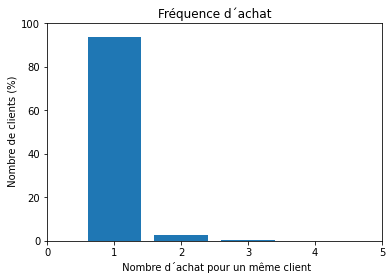

In [20]:
var = df['customer_unique_id'].value_counts()

b = []
for ind in range(len(var.unique())):
    a = var.unique()[ind]
    b.append( (var==a).sum()*100/df.shape[0] )

plt.bar(var.unique(),b)
plt.axis([0,5,0,100]);
plt.title('Fréquence d´achat')
plt.ylabel(' Nombre de clients (%)')
plt.xlabel(' Nombre d´achat pour un même client')
plt.rcParams.update({'font.size': 12})

Peu de clients enregistrés (3%) ayant effectués plusieurs commandes

### Représentation graphique

In [21]:
## numerical and categorical values
X_num = df.loc[:,(df.dtypes=='float64') | (df.dtypes=='int64')]
X_object = df.loc[:,df.dtypes=='object']

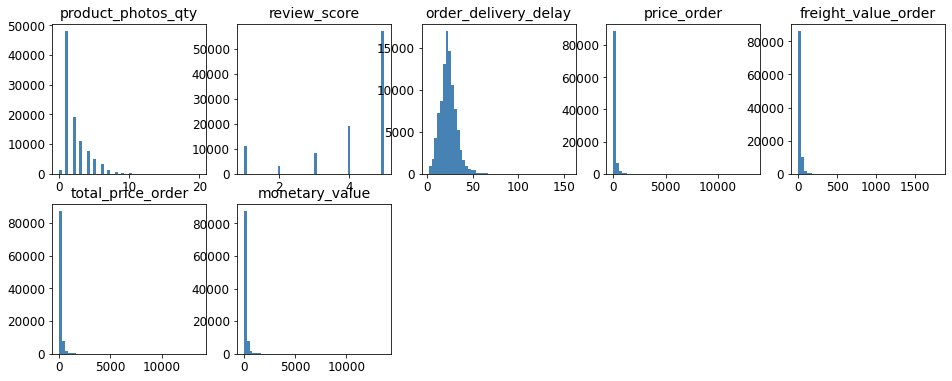

In [22]:
## numerical values histograms 
X=X_num
fig = plt.figure(figsize=(16, 16))
for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(5,5, (feat_idx+1))
    h = ax.hist(X.iloc[:, feat_idx], bins=50, color='steelblue', edgecolor='none')
    ax.set_title(X.columns[feat_idx], fontsize=14)

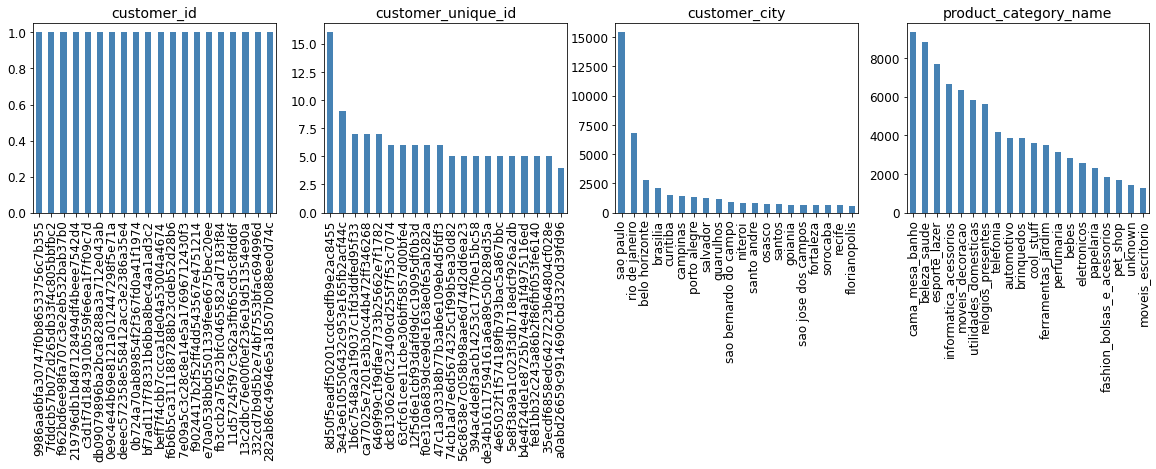

In [23]:
## categorical values histograms
X= X_object.copy()
fig = plt.figure(figsize=(20, 16))
for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(4,4, (feat_idx+1))
    X.iloc[:, feat_idx].value_counts().iloc[:20].plot(kind="bar",color='steelblue', edgecolor='none')
    ax.set_title(X.columns[feat_idx], fontsize=14)


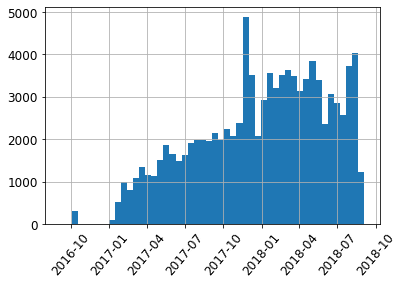

In [24]:
## histogram, time purchase range
df['order_purchase_timestamp'].hist(bins=50)
plt.xticks(rotation=50);

## Enregistrement des données

In [25]:
mon_fichier = 'donnee/olist.csv'
df.to_csv(mon_fichier,index=False)

In [26]:
df.shape

(98665, 12)

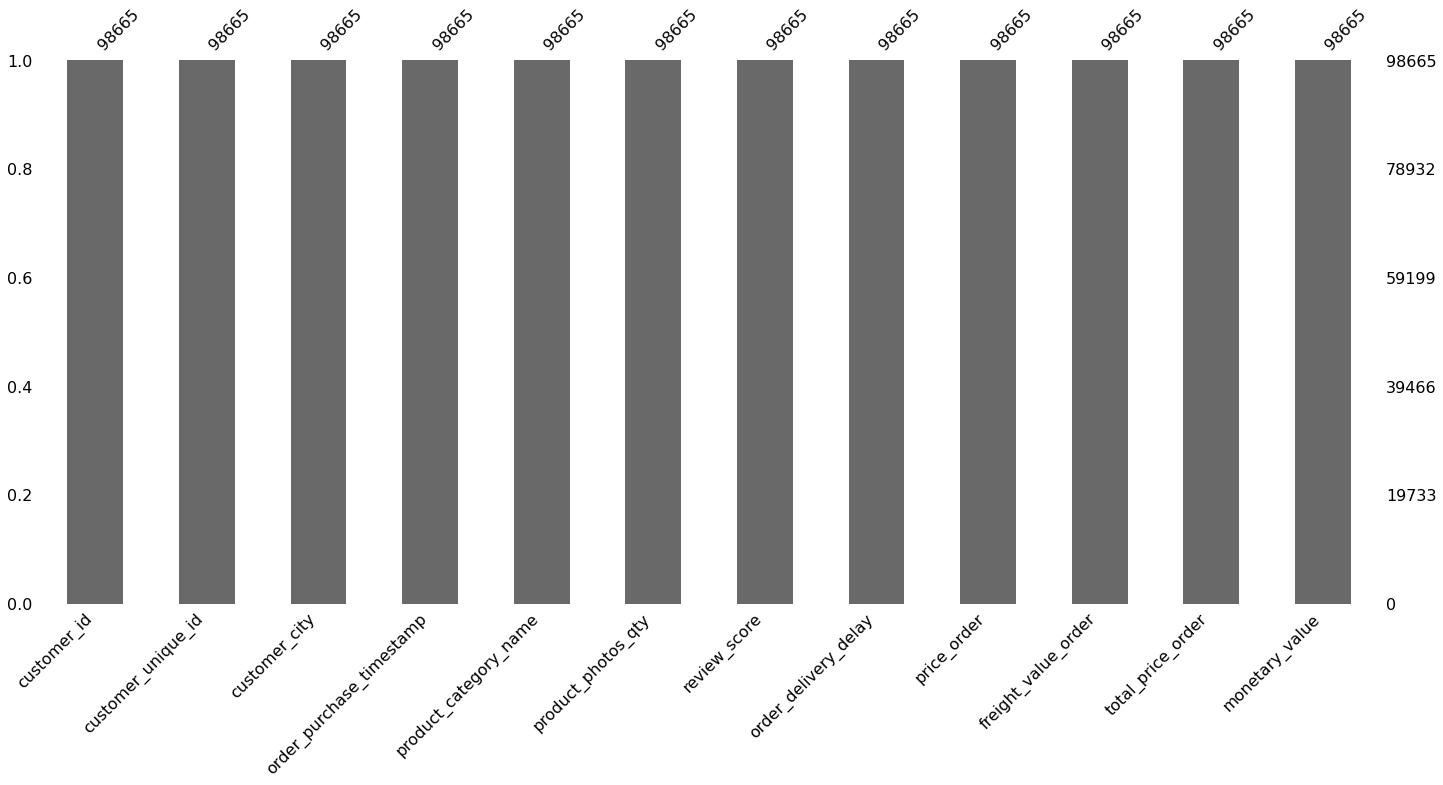

In [27]:
## missing values
mso.bar(df);